In [55]:
%load_ext lab_black

In [56]:
import pickle
import pandas as pd
from collections import defaultdict
import re
import numpy as np
import os
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

In [57]:
plt.style.use("ggplot")

In [58]:
!ls -lhrt ../data/intermediate/ | tail

-rw-r--r--  1 navy  staff   3.9K Sep 12 17:47 report_urls1631461626513555000.pickle
-rw-r--r--  1 navy  staff   5.7K Sep 12 17:47 scraped_financials1631461626513555000.csv
-rw-r--r--  1 navy  staff   2.1K Sep 12 18:05 report_urls1631462748278026000.pickle
-rw-r--r--  1 navy  staff   7.0M Sep 12 18:05 report_pages_0.pickle
-rw-r--r--  1 navy  staff   3.2K Sep 12 18:05 scraped_financials1631462748278026000.csv
-rw-r--r--  1 navy  staff   2.0G Sep 12 19:00 report_pages_1.pickle
-rw-r--r--  1 navy  staff   1.7G Sep 12 19:47 report_pages_2.pickle
-rw-r--r--  1 navy  staff    73K Sep 12 20:25 report_urls1631471121018502000.pickle
-rw-r--r--  1 navy  staff   1.1G Sep 12 20:25 report_pages_3.pickle
-rw-r--r--  1 navy  staff   114K Sep 12 20:25 scraped_financials1631471121018502000.csv


In [59]:
files = [
    "scraped_financials1631471121018502000.csv",
]

dfs = [
    pd.read_csv(os.path.join("../data/intermediate", file), index_col=0)
    for file in files
]

companies = pd.concat(dfs).reset_index(drop=True)

In [60]:
companies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 808 entries, 0 to 807
Data columns (total 10 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   total_current_assets                      634 non-null    float64
 1   total_current_liabilities                 632 non-null    float64
 2   long-term_debt                            534 non-null    float64
 3   total_liabilities                         693 non-null    float64
 4   total_equity                              274 non-null    float64
 5   total_stockholders.?.?equity              330 non-null    float64
 6   earnings_per_share_attributable.*diluted  8 non-null      float64
 7   CIK                                       808 non-null    int64  
 8   date_filled                               808 non-null    object 
 9   url                                       808 non-null    object 
dtypes: float64(7), int64(1), object(2)
mem

In [61]:
pd.set_option("max_colwidth", 500)
companies.tail()

,total_current_assets,total_current_liabilities,long-term_debt,total_liabilities,total_equity,total_stockholders.?.?equity,earnings_per_share_attributable.*diluted,CIK,date_filled,url
803,NaN,NaN,NaN,NaN,NaN,NaN,NaN,815097,2010-11-30,https://www.sec.gov/Archives/edgar/data/0000815097/000119312511018320/d10k.htm
804,NaN,NaN,NaN,NaN,NaN,NaN,NaN,815097,2009-11-30,https://www.sec.gov/Archives/edgar/data/0000815097/000119312510016470/d10k.htm
805,NaN,NaN,NaN,NaN,NaN,NaN,NaN,815097,2008-11-30,https://www.sec.gov/Archives/edgar/data/0000815097/000119312509013746/d10k.htm
806,NaN,NaN,NaN,NaN,NaN,NaN,NaN,815097,2007-11-30,https://www.sec.gov/Archives/edgar/data/0000815097/000116923208000308/d73197_10-k.htm
807,8524.0,5110.0,10227.0,18515.0,6578.0,NaN,NaN,1783180,2020-12-31,https://www.sec.gov/Archives/edgar/data/0001783180/000178318021000011/carr-20201231.htm


In [62]:
len(companies["CIK"].unique())

89

In [63]:
# FIXME some companies have duplicate entries for date_filled. Amendments?
print(companies.shape)
companies.drop_duplicates(subset=["CIK", "date_filled"], inplace=True)
companies.shape

(808, 10)


(796, 10)

In [64]:
companies["date_filled"] = pd.to_datetime(companies["date_filled"])
companies["CIK"] = companies["CIK"].astype("category")
companies["current_ratio"] = (
    companies["total_current_assets"] / companies["total_current_liabilities"]
)

In [65]:
pd.set_option("max_colwidth", 400)


def get_fiscal_year(dt):
    if dt.month < 6:
        return dt.year - 1
    else:
        return dt.year


companies["fiscal_year"] = companies["date_filled"].apply(lambda x: get_fiscal_year(x))
companies[
    ["total_current_assets", "total_current_liabilities", "url", "fiscal_year"]
].head()

,total_current_assets,total_current_liabilities,url,fiscal_year
0,14982.0,7948.0,https://www.sec.gov/Archives/edgar/data/0000066740/000155837021000737/mmm-20201231x10k.htm,2020
1,12971.0,9222.0,https://www.sec.gov/Archives/edgar/data/0000066740/000155837020000581/mmm-20191231x10k62bf35.htm,2019
2,13709.0,7244.0,https://www.sec.gov/Archives/edgar/data/0000066740/000155837019000470/mmm-20181231x10k.htm,2018
3,14277.0,7687.0,https://www.sec.gov/Archives/edgar/data/0000066740/000155837018000535/mmm-20171231x10k.htm,2017
4,11726.0,6219.0,https://www.sec.gov/Archives/edgar/data/0000066740/000155837017000479/mmm-20161231x10k.htm,2016


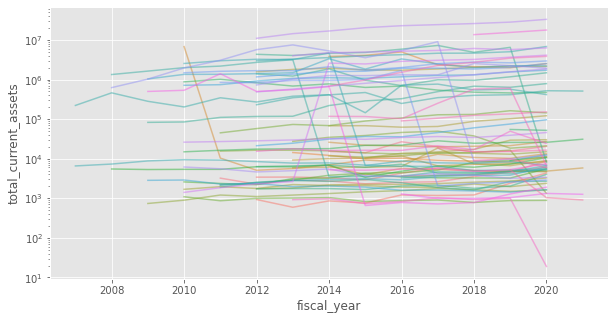

In [66]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(
    data=companies,
    x="fiscal_year",
    y="total_current_assets",
    hue="CIK",
    ax=ax,
    legend=False,
    alpha=0.5,
)
ax.set(yscale="log")
plt.show()

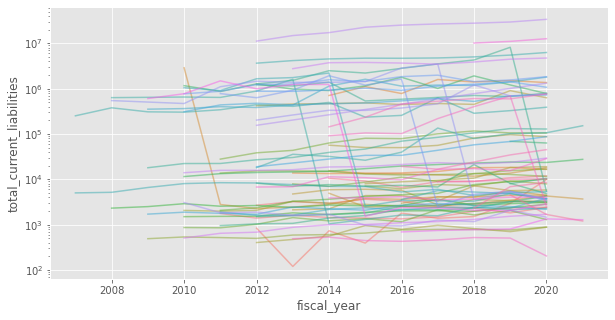

In [67]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(
    data=companies,
    x="fiscal_year",
    y="total_current_liabilities",
    hue="CIK",
    ax=ax,
    legend=False,
    alpha=0.5,
)
ax.set(yscale="log")
plt.show()

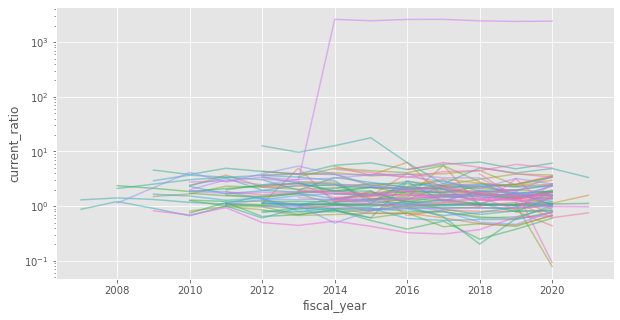

In [68]:
fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.lineplot(
    data=companies,
    x="fiscal_year",
    y="current_ratio",
    hue="CIK",
    legend=False,
    alpha=0.5,
)
ax.set(yscale="log")
plt.show()

In [75]:
companies["fiscal_year"].unique()

array([2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010,
       2009, 2008, 2007, 2021, 2006, 2005, 2004, 2003, 2002, 2001, 2000,
       1999, 1998, 1997, 1996])

(10.0, 26.0)

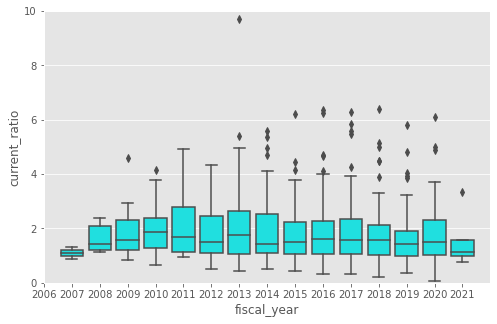

In [84]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(data=companies, x="fiscal_year", y="current_ratio", ax=ax, color="cyan")
ax.set_ylim([0, 10])
ax.set_xlim([10, 26])

In [148]:
# save processed company dataset
# companies.to_csv('../data/processed/scraped_companies_2021.csv')

In [28]:
with open("../data/intermediate/report_pages1631457594226786000.pickle", "rb") as f:
    pages = pickle.load(f)

In [29]:
ciks = list(pages.keys())
len(ciks)

29

In [32]:
page = pages[ciks[0]]
len(page[0])

9544083

In [37]:
page[0][:1000]

'<?xml version=\'1.0\' encoding=\'UTF-8\'?>\n\n      <!-- iXBRL document created with: Toppan Merrill Bridge iXBRL 9.6.7629.27231 -->\n      <!-- Based on: iXBRL 1.1 -->\n      <!-- Created on: 2/4/2021 6:49:37 PM -->\n      <!-- iXBRL Library version: 1.0.7629.27238 -->\n      <!-- iXBRL Service Job ID: 575aa863-2bf3-4f5d-b976-b42e353444e1 -->\n\n  <html xmlns:stpr="http://xbrl.sec.gov/stpr/2018-01-31" xmlns:us-gaap="http://fasb.org/us-gaap/2020-01-31" xmlns:link="http://www.xbrl.org/2003/linkbase" xmlns:country="http://xbrl.sec.gov/country/2020-01-31" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xmlns:xbrldt="http://xbrl.org/2005/xbrldt" xmlns:ixt-sec="http://www.sec.gov/inlineXBRL/transformation/2015-08-31" xmlns:exch="http://xbrl.sec.gov/exch/2020-01-31" xmlns:srt="http://fasb.org/srt/2020-01-31" xmlns:ix="http://www.xbrl.org/2013/inlineXBRL" xmlns:ref="http://www.xbrl.org/2006/ref" xmlns:xbrli="http://www.xbrl.org/2003/instance" xmlns:dei="http://xbrl.sec.gov/dei/2020-01-

In [38]:
ciks[0]

66740

In [56]:
soup = BeautifulSoup(page[0], "html.parser")

In [57]:
ps = soup.findAll("p")
text = "\n".join([p.text for p in ps])

In [66]:
with open("../data/intermediate/text.pickle", "wb") as f:
    pickle.dump(text, f)

with open("../data/intermediate/content.pickle", "wb") as f:
    pickle.dump(soup.text, f)

In [69]:
!ls -lh ../data/intermediate/text.pickle ../data/intermediate/content.pickle

-rw-r--r--  1 navy  staff   713K Sep 12 17:03 ../data/intermediate/content.pickle
-rw-r--r--  1 navy  staff   567K Sep 12 17:03 ../data/intermediate/text.pickle


In [70]:
713 / 567

1.2574955908289243